# Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import time
from skimage.metrics import structural_similarity as ssim

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Initial Images

In [2]:
img = cv2.imread('assets/main_image.png', 0)

In [3]:
img_wat = cv2.imread('assets/watermark_image.png', 0)

# Normalisation

Image normalization is a procedure to transform the image into standard image such that it contains detailed information of input image. It provides better resistance against the geometric attacks. The detailed steps of image normalization procedure are mentioned below:

1. Finding Moments
2. Translation 
3. Shearing
4. Scaling

The implementation of each of the above mentioned funnctions can be found in the subsequent cells

## Finding Moments

Code contributed by Sachin Prasanna (211IT058)

In [4]:
def findMoments (img):

    _, img = cv2.threshold(img, 100, 252, cv2.THRESH_BINARY)  #this step can be optional as well.
    moment = cv2.moments(img)

    #creating a dictionary to store the information
    variables_dict = {}
    t_alpha = int(moment['m10']/moment['m00'])
    t_beta = int(moment['m01']/moment['m00'])
    mu_03 = moment['mu03']
    mu_12 = moment['mu12']
    mu_21 = moment['mu21']
    mu_30 = moment['mu30']
    mu_11 = moment['mu11']
    mu_20 = moment['mu20']

    coeff = [mu_03, 3*mu_12, 3*mu_21, mu_30]
    betas = np.roots(coeff)

    betas_real = []
    for i in range(len(betas)):
        if np.isreal(betas[i]):
            betas_real.append(betas[i])

    #taking the median of betas_real
    if(len(betas_real) > 1):
        beta = np.median(betas_real)
    else:
        beta = betas_real[0]

    beta = np.real(beta)

    lambda_ = mu_11/mu_20

    variables_dict['t_alpha'] = t_alpha
    variables_dict['t_beta'] = t_beta
    variables_dict['beta'] = beta
    variables_dict['lambda'] = lambda_

    return variables_dict

In [5]:
moments_dict = findMoments(img)
moments_dict

{'t_alpha': 279,
 't_beta': 235,
 'beta': 1.7178507080174241,
 'lambda': 0.07295653494397585}

## Translation

Code contributed by Abhayjit Singh Gulati (211IT085)

In [6]:
def translate (img, variables_dict):

    t_alpha = variables_dict['t_alpha']
    t_beta = variables_dict['t_beta']

    rows, cols = img.shape
    M = np.float32([[1, 0, t_alpha], [0, 1, t_beta]])
    img_translated = cv2.warpAffine(img, M, (cols, rows))

    return img_translated

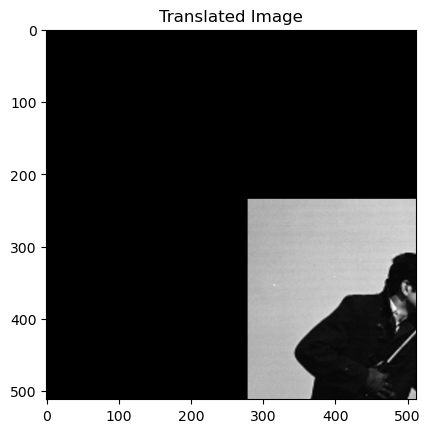

In [7]:
img_translated = translate(img, moments_dict)
cv2.imwrite('generated_assets/final_translated.png', img_translated)
# plt.imshow(img_translated, cmap='gray')
# plt.title('Translated Image')
# plt.show()

## Shearing

Code contributed by Sachin Prasanna (211IT058)

In [8]:
def shear(img, variables_dict, direction):

    beta = variables_dict['beta']
    lambda_ = variables_dict['lambda']

    rows, cols = img.shape

    if direction == 'x':
        M = np.float32([[1, beta, 0], [0, 1, 0]])
    elif direction == 'y':
        M = np.float32([[1, 0, 0], [lambda_, 1, 0]])

    img_sheared = cv2.warpAffine(img, M, (cols, rows))

    return img_sheared

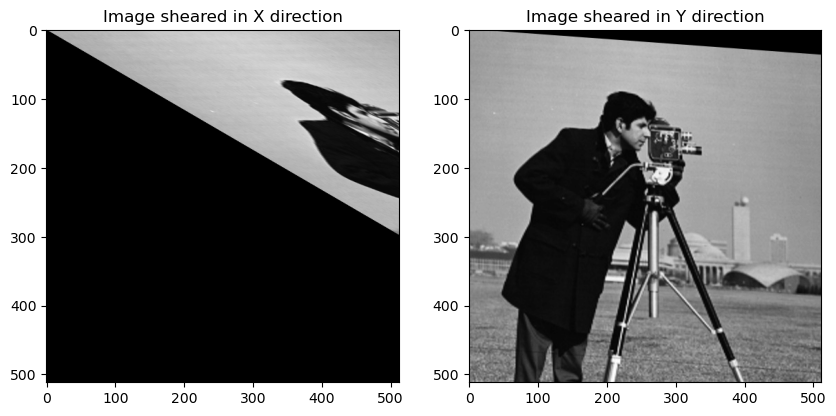

In [9]:
img_sheared_x = shear(img, moments_dict, 'x')
img_sheared_y = shear(img, moments_dict, 'y')

cv2.imwrite('generated_assets/final_sheared_x.png', img_sheared_x)
cv2.imwrite('generated_assets/final_sheared_y.png', img_sheared_y)

#show both images side by side
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(img_sheared_x, cmap='gray')
# ax[0].set_title('Image sheared in X direction')
# ax[1].imshow(img_sheared_y, cmap='gray')
# ax[1].set_title('Image sheared in Y direction')
# plt.show()

## Scaling

Code contributed by Rounak Jain (211IT055)

In [10]:
def scale(img, variables_dict, alpha, delta):

    #scaling by alpha in x direction and delta in y direction
    rows, cols = img.shape
    M = np.float32([[alpha, 0, 0], [0, delta, 0]])
    img_scaled = cv2.warpAffine(img, M, (cols, rows))

    return img_scaled

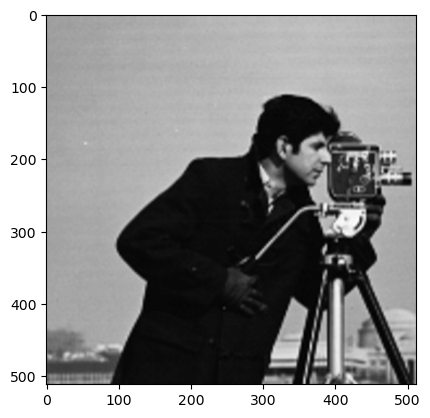

In [11]:
img_scaled = scale(img, moments_dict, 1.5, 1.5)
# plt.imshow(img_scaled, cmap='gray')
cv2.imwrite('generated_assets/final_img_scaled.png', img_scaled)

## Normalisation Function: Combining into one

Combining the work of all 3 members in into the Normalisation Algorithm.

Code contributed by Rounak Jain (211IT055)

In [12]:
def normalisation(img):

    variables_dict = findMoments(img)
    img_translated = translate(img, variables_dict)
    img_sheared_x = shear(img_translated, variables_dict, 'x')
    img_sheared_y = shear(img_sheared_x, variables_dict, 'y')
    img_scaled = scale(img_sheared_y, variables_dict, 0.05, 0.05)

    return img_scaled

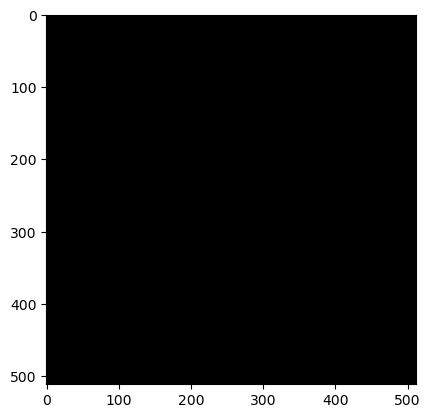

In [13]:
img_normalised = normalisation(img)
cv2.imwrite('generated_assets/final_img_normalised.png', img_normalised)
# plt.imshow(img_normalised, cmap='gray')

# Randomised Singular Value Decomposition (RSVD)

RSVD plays an important role to perform matrix factorization in image processing. This is because the computational cost of RSVD is less than SVD. The time complexity of RSVD is 𝑂(𝑖𝑗𝑟), where size of input matrix is denoted as 𝑖 × 𝑗 and rank of this matrix is termed as r.

The implementation of RSVD is shown below.

Code contributed by Sachin Prasanna (211IT058)

In [14]:
def rsvd(A, r):

    m, n = A.shape

    P = np.random.randn(n, r)
    Z = A @ P
    Q, _ = np.linalg.qr(Z, mode='reduced')
    B = Q.T @ A

    # Finding the SVD of REDUCED MATRIX B
    Uhat, S, V = np.linalg.svd(B, full_matrices=False)

    U = Q @ Uhat

    return U, S, V

When we take our target rank of matrix as 200, we can clearly see the difference in shape of the decomposed matrices as shown in the output below. Also, the time taken is lesser in the case of RSVD as opposed to SVD.

In [15]:
start = time.time()
u_rsvd, s_rsvd, v_rsvd = rsvd(img, 200)   #target rank = 200
end = time.time()
print('Time taken for rsvd:', end - start)

start1 = time.time()
u_svd, s_svd, v_svd = np.linalg.svd(img, full_matrices=False)
end1 = time.time()
print('Time taken for svd:', end1 - start1)

print("Shapes of decomposed matrices U, Sigma, V with RSVD: ", u_rsvd.shape, s_rsvd.shape, v_rsvd.shape)
print("Shapes of decomposed matrices U, Sigma, V with SVD: ", u_svd.shape, s_svd.shape, v_svd.shape)

Time taken for rsvd: 0.13697052001953125
Time taken for svd: 0.2091045379638672
Shapes of decomposed matrices U, Sigma, V with RSVD:  (512, 200) (200,) (200, 512)
Shapes of decomposed matrices U, Sigma, V with SVD:  (512, 512) (512,) (512, 512)


Both the SVD and RSVD are almost similar as well when reconstruced back to original image as shown in the outputs below.

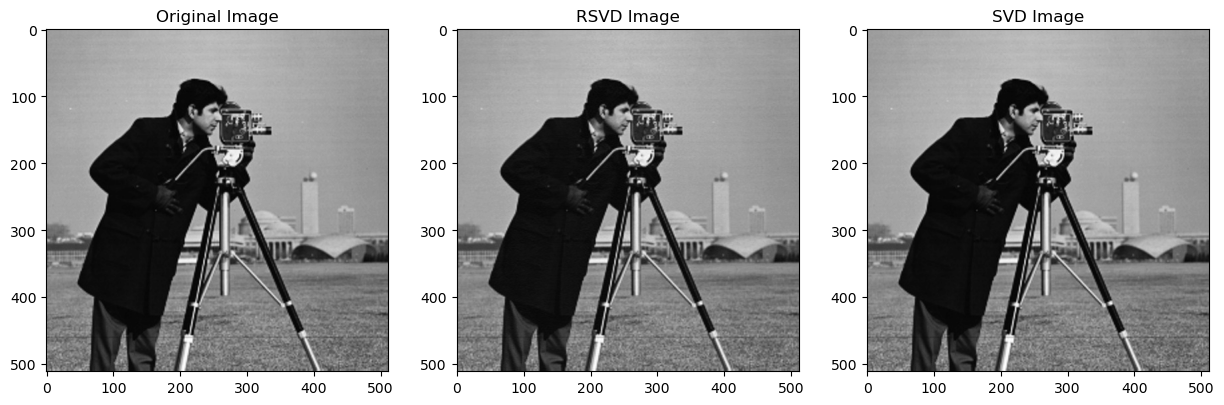

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(u_rsvd @ np.diag(s_rsvd) @ v_rsvd, cmap='gray')
axs[1].set_title('RSVD Image')
axs[2].imshow(u_svd @ np.diag(s_svd) @ v_svd, cmap='gray')
axs[2].set_title('SVD Image')
plt.show()

# Redundant Discrete Wavelet Transform (RDWT)


The Redundant Discrete Wavelet Transform (RDWT) for images is a variant of the discrete wavelet transform (DWT) that incorporates redundancy by allowing overlapping wavelet coefficients, offering improved representation accuracy and flexibility for tasks like image denoising and compression. This redundancy enables more robust signal representation and better preservation of image features compared to traditional DWT.

The implementation of RDWT is shown below.

Code contributed by Abhayjit Singh Gulati (211IT085)

In [17]:
def rdwt(img):

    # Performing the Redundant Discrete Wavelet Transform (RDWT) with Haar wavelet
    coeffs_org = pywt.swt2(img, 'haar', level=1, axes=(0, 1))

    A1, (B1, C1, D1) = coeffs_org[0]

    return A1, B1, C1, D1

As observed from the output below, the decomposition typically results in four subbands:

**Approximation (LL)**: Contains the low-frequency information and represents the coarse approximation of the original image.

**Horizontal (HL)**: Contains the high-frequency information in the horizontal direction, capturing details and edges that are primarily horizontal.

**Vertical (LH)**: Contains the high-frequency information in the vertical direction, capturing details and edges that are primarily vertical.

**Diagonal (HH)**: Contains the high-frequency information in both horizontal and vertical directions, capturing diagonal edges and texture details.

All the four subbands are plotted in the outputs.

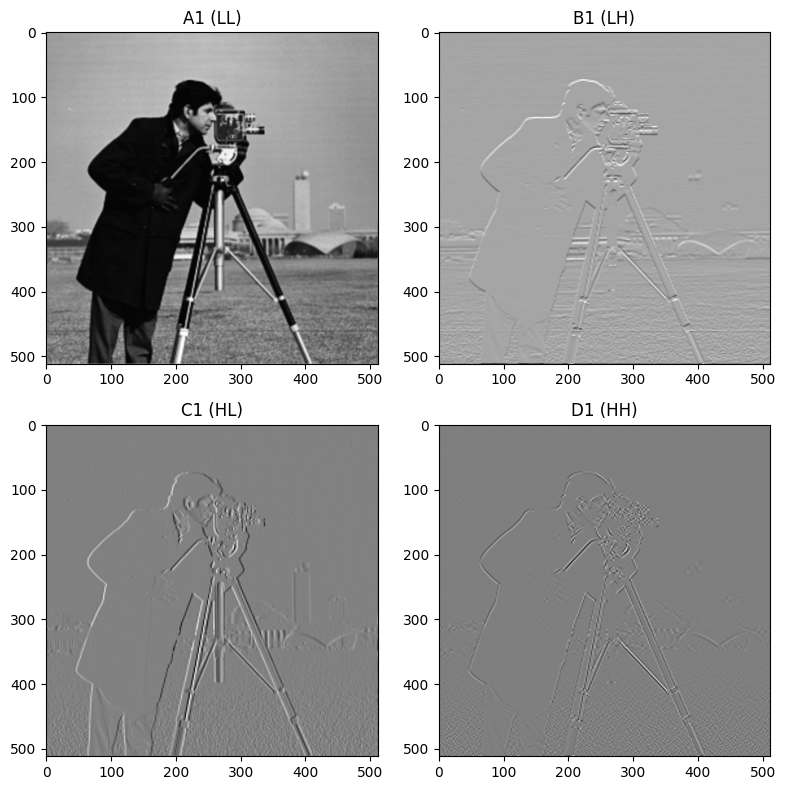

In [18]:
A1, B1, C1, D1 = rdwt(img)

#Plotting the subbands
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(A1, cmap='gray'), axs[0, 0].set_title('A1 (LL)')
axs[0, 1].imshow(B1, cmap='gray'), axs[0, 1].set_title('B1 (LH)')
axs[1, 0].imshow(C1, cmap='gray'), axs[1, 0].set_title('C1 (HL)')
axs[1, 1].imshow(D1, cmap='gray'), axs[1, 1].set_title('D1 (HH)')
plt.tight_layout()
plt.show()

# Principal Component Analysis

Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while preserving the most important information. It identifies orthogonal axes, called principal components, along which the data exhibits the maximum variance, aiding in visualization, compression, and noise reduction.

It is implemented below.

Code contributed by Rounak Jain (211IT055)

In [19]:
def pca(X):

    # Standardizing the data
    X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    covariance_matrix = np.cov(X_standardized, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sorting the eigenvalues in descending order and the eigenvectors will rearrange accordingly.
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Selecting Principle Components based on the Kaiser criterion
    average_eigenvalues = np.mean(eigenvalues)
    num_components = np.sum(eigenvalues > average_eigenvalues)

    # Selecting the top k eigenvectors (the principal components)
    selected_eigenvectors = eigenvectors[:, :num_components]
    projected_data = np.dot(X_standardized, selected_eigenvectors)

    return projected_data, selected_eigenvectors

Reducing the components of an image using PCA, and plotting it back as shown by the output below.

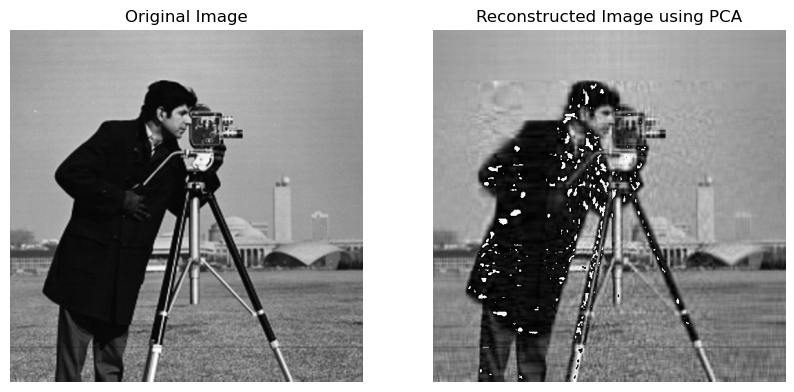

In [20]:
image_2d = img.reshape(-1, img.shape[1])
projected_data, selected_eigenvectors = pca(image_2d)

reconstructed_image = np.dot(projected_data, selected_eigenvectors.T)
reconstructed_image = (reconstructed_image * np.std(image_2d, axis=0)) + np.mean(image_2d, axis=0)
reconstructed_image = np.uint8(reconstructed_image.reshape(img.shape))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image using PCA')
plt.axis('off')

plt.show()

# Arnold Cat Maps

Arnold cat map is one of the most popular scrambling methods, which was first introduced by V. I. Arnold. It contains several properties in terms of simplicity and periodicity. The scrambling operation is performed by altering the pixel values of mark image. Besides the recovery of mark image is possible only if the secret key is used.

The implementation of Arnold Cat Maps is shown below.

Code contributed by Abhayjit Singh Gulati (211IT085)

In [21]:
def arnold_scramble(img, iterations):
    rows, cols = img.shape
    new_img = np.zeros_like(img)

    #fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Create a row of 4 subplots

    for ctr in range(0, iterations):
        for i in range(0, rows):
            for j in range(0, cols):
                new_i = (i + j) % rows
                new_j = (i + (2*j)) % cols
                new_img[new_i, new_j] = img[i, j]

        img = new_img.copy()

        # Visualizing the Arnold Cat transform upto first 40 iterations, every 10 iterations
        # if ctr % 10 == 0 and ctr < 40:
        #     ax = axes[ctr // 10]
        #     ax.imshow(new_img, cmap='gray', interpolation='bicubic')
        #     ax.set_title(f"Iteration {ctr}")
        #     ax.axis('off')

    # plt.tight_layout()
    # plt.show()

    return new_img

In [22]:
scrambled_img = arnold_scramble(img, 53)

Original Image: 


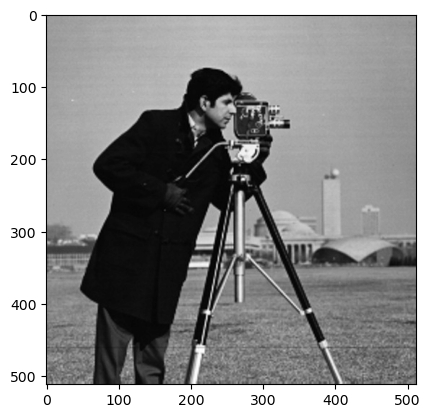

Scrambled Image: (After 53 iterations)


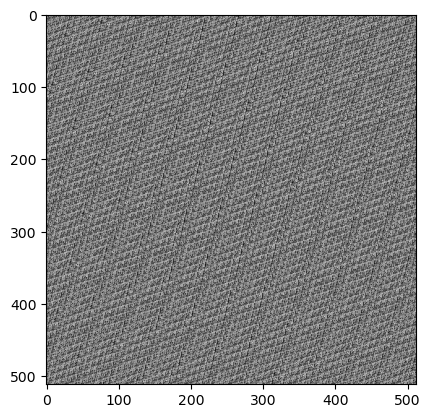

In [23]:
print('Original Image: ')
plt.imshow(img, cmap='gray')
plt.show()

print('Scrambled Image: (After 53 iterations)')
plt.imshow(scrambled_img, cmap='gray')
plt.show()

# Algorithm 1: Determination of Principal Cofficients

The simplified concept of PCA based fusion is shown is implemented. It is utilized to compute the normalized principal component as a factor for embedding the mark information into the host media. First, covariance is calculated between host and mark image and then normalized principal coefficients are obtained with the help of Eigenvalues.

Code contributed by Sachin Prasanna (211IT058)

In [25]:
def algorithm_1(path1, path2):

    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)

    A1, B1, C1, D1 = rdwt(img1)
    A2, B2, C2, D2 = rdwt(img2)

    Uh, Sh, Vh = rsvd(D1, 200)  # target rank is 200
    Uw, Sw, Vw = rsvd(D2, 200)  # target rank is 200

    covariance_matrix = np.cov(Sh, Sw)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sorting the eigenvalues in descending order and the eigenvectors will rearrange accordingly.
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    diag = np.diag(eigenvalues)

    if(diag[0][0] > diag[1][1]):
        PC1 = eigenvectors[0][0]/(eigenvectors[0][0] + eigenvectors[1][0])
        PC2 = eigenvectors[1][0]/(eigenvectors[0][0] + eigenvectors[1][0])

    else:
        PC1 = eigenvectors[0][1]/(eigenvectors[0][1] + eigenvectors[1][1])
        PC2 = eigenvectors[1][1]/(eigenvectors[0][1] + eigenvectors[1][1])

    return PC1, PC2

Using the algorithm, the calculated components are outputed.

In [26]:
path1 = 'cameraman.png'
path2 = 'star.png'

PC1, PC2 = algorithm_1(path1, path2)

print('Principal Component 1:', PC1)
print('Principal Component 2:', PC2)

Principal Component 1: 0.3247680412669662
Principal Component 2: 0.6752319587330338


# Algorithm 2: Watermark Embedding

Image normalization procedure is utilized to transform the original image, ‘𝑂𝑟𝑔𝑖𝑚𝑔 ’ into normalized image, ‘𝑁𝑜𝑟𝑚𝑖𝑚𝑔 ’. Further, '𝑁𝑜𝑟𝑚𝑖𝑚𝑔' and mark image, ‘𝑊𝑎𝑡𝑖𝑚𝑔' are transformed using RDWT and RSVD respectively. Furthermore, PCA fusion is employed to compute the optimal embedding factor for embedding purpose. The principal component of mark image is concealed inside cover image. Furthermore, inverse operation of RSVD and RDWT is performed to compute the marked image, ‘𝑀𝑎𝑟𝑘𝑖𝑚𝑔 ’. Lastly, Arnold cat map is performed on 𝑀𝑎𝑟𝑘𝑖𝑚𝑔 enhance the additional security of proposed scheme.

This algorithm requires the computation of the Inverse Reduntant Wavelet Transform as well, which is implemented below first followed by Algorithm 2.

Code contributed by Sachin Prasanna (211IT058)

In [27]:
import numpy as np
import pywt

def irdwt(coefficients, wavelet='haar'):
    # Inverse wavelet transform
    irdwt_result = pywt.idwt(coefficients[0], coefficients[1], wavelet, axis=-1)
    return irdwt_result

Algorithm 2 is implemented below:

In [28]:
def algorithm_2(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    img1_norm = normalisation(img1)

    # Compute wavelet coefficients for img1
    coeffs1 = rdwt(img1)
    A1, B1, C1, D1 = coeffs1
    U1, S1, V1 = rsvd(D1, 512)

    # Compute wavelet coefficients for img2
    coeffs2 = rdwt(img2)
    A2, B2, C2, D2 = coeffs2
    U2, S2, V2 = rsvd(D2, 512)

    PC1, PC2 = algorithm_1(path1, path2)
    S_PC = np.dot(U2, S2)

    S_emb = PC1*S1 + PC2*S_PC
    S_emb = np.diag(S_emb)

    D_new = U1 @ S_emb @ V1.T

    # Combine wavelet coefficients for inverse transform
    combined_coeffs = [A1, B1, C1, D_new]

    mark_img = irdwt(combined_coeffs)

    enc_img = arnold_scramble(mark_img, 53)   # 53 is the key here
    return enc_img

This algorithm is yet to evaluated for performance and output, and hence will be done in the coming week.

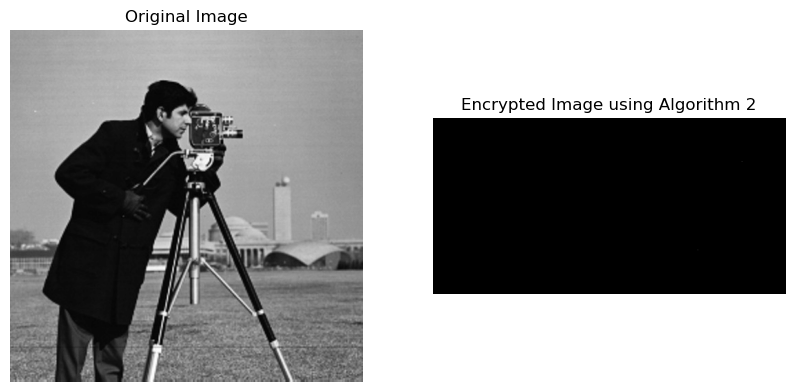

In [29]:
path1 = 'cameraman.png'
path2 = 'star.png'

enc_mark_img = algorithm_2(path1, path2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enc_mark_img, cmap='gray')
plt.title('Encrypted Image using Algorithm 2')
plt.axis('off')
plt.show()

# Algorithm 3: Watermarking Extraction

## Inverse Arnold Scramble

In [43]:
def inverse_arnold_scramble(img, iterations):
    rows, cols = img.shape
    new_img = np.zeros_like(img)

    for ctr in range(0, iterations):
        for i in range(0, rows):
            for j in range(0, cols):
                new_i = (i - j) % rows
                new_j = ((-i) + (2 * j)) % cols
                new_img[new_i, new_j] = img[i, j]

        img = new_img.copy()

    return new_img

In [46]:
def algorithm_3(enc_mark_img,path2,PC1,PC2):
   # enc_mark_img = cv2.imread(path, 0)
    dec_mark_img = inverse_arnold_scramble(enc_mark_img,53)
    A3, B3, C3, D3= rdwt(dec_mark_img)
    U3, S3, V3 = rsvd(D3, 512)

    img2 = cv2.imread(path2, 0)

    A2, B2, C2, D2 = rdwt(img2)
    U2, S2, V2 = rsvd(D2, 512)
    Ext_PC=(1/PC2 *(S3 - PC1 * S2))

    D_mod = Ext_PC @ V2.T
     # Combine wavelet coefficients for inverse transform
    combined_coeffs = [A2, B2, C2, D_mod]
    Rec_Wat_img = irdwt(combined_coeffs)

    # rec_wat_img is 512x1024, can you make downscale to 512x512
    Rec_Wat_img = cv2.resize(Rec_Wat_img, (512, 512))
    return Rec_Wat_img

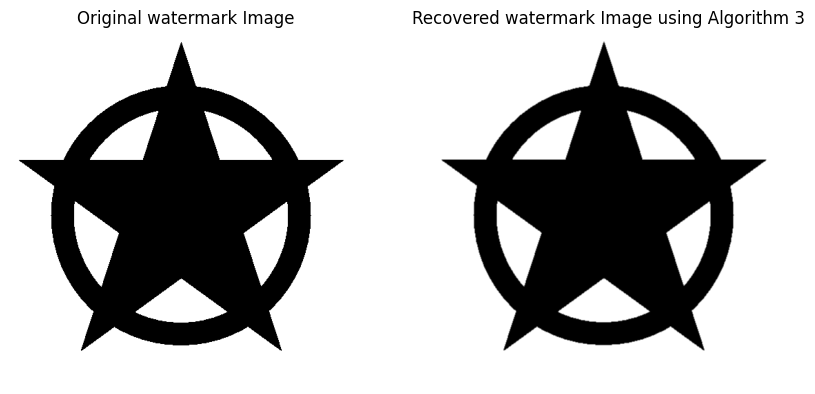

In [49]:
path1 = 'cameraman.png'
path2 = 'star.png'

PC1, PC2= algorithm_1(path1, path2)
enc_mark_img = algorithm_2(path1, path2)

Rec_Wat_img= algorithm_3(enc_mark_img, path2, PC1, PC2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_wat, cmap='gray')
plt.title('Original watermark Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Rec_Wat_img, cmap='gray')
plt.title('Recovered watermark Image using Algorithm 3')
plt.axis('off')

plt.show()

# Performance Metrics

## PSNR: Peak Signal to Noise Ratio

In [63]:
def calculate_psnr(img1, img2):

    img1 = np.float32(img1)
    img2 = np.float32(img2)

    mse = np.mean((img1 - img2) ** 2)
    max_pixel = 255.0

    # PSNR value
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

In [64]:
psnr_score = calculate_psnr(img_wat, Rec_Wat_img)

In [65]:
print('PSNR:', psnr_score)

PSNR: 9.553839254180604


## SSIM: Structural Similarity Index

In [66]:
def calculate_ssim(img1, img2):

    img1 = np.float32(img1)
    img2 = np.float32(img2)

    # Calculate SSIM
    similarity_index = ssim(img1, img2, data_range=img2.max() - img2.min())
    return similarity_index

In [67]:
ssim_value = calculate_ssim(img_wat, Rec_Wat_img)

In [68]:
print('SSIM:', ssim_value)

SSIM: 0.9350738425343398


## NC:  Normalized Cross-Correlation

In [69]:
def calculate_ncc(img1, img2):
    
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0

    mean1 = np.mean(img1)
    mean2 = np.mean(img2)

    img1 -= mean1
    img2 -= mean2

    cross_corr = np.sum(img1 * img2)
    
    std1 = np.sqrt(np.sum(img1 ** 2))
    std2 = np.sqrt(np.sum(img2 ** 2))

    # Calculate NCC score
    ncc_score = cross_corr / (std1 * std2)

    return ncc_score

In [70]:
nc_value = calculate_ncc(img_wat, Rec_Wat_img)

In [71]:
print('NC:', nc_value)

NC: 0.99319273
